In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
import xgboost as xgb

In [107]:
# Data from: https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

In [108]:
data = pd.read_csv('Hotel_Reviews.csv')

# remove rows with no reviews
data = data[(data['Negative_Review'] != 'No Negative') | (data['Positive_Review'] != 'No Positive')]
data.reset_index(drop=True, inplace=True)

In [ ]:
data.info()

In [ ]:
#how many unqiue in each column
#for i in data.columns:
#    print(i, len(data[i].unique()))

In [ ]:
#Drop unwanted columns
data.drop(['Hotel_Name','Hotel_Address','Review_Date','days_since_review'],  axis=1, inplace=True)
data['Average_Score'].astype(float)

In [ ]:
# Benchmark - error if you always guessed the average (1.18)
mean_absolute_error(data['Average_Score'], data['Reviewer_Score'])

In [ ]:
#correcting tags from 55,000 to a few - started as a list of strings that looked like lists of strings
#tags = data.Tags

#import ast
#new_tags = []
#for i in tags:
#    new_tags.append(ast.literal_eval(i))

# check most common tags
from collections import Counter
list_for_counting = []
for i in new_tags:
    for t in i:
        list_for_counting.append(t)
    
c = Counter(list_for_counting)
c.most_common(20)      

In [ ]:
'''# feature engineering tags to reduce columns
for index, i in enumerate(new_tags):
    for idx, t in enumerate(i):
        if t not in ['Stayed 1-2 nights','Stayed 3-4 nights', 'Stayed 5+ nights', 'Fancy', 'Budget', 'Medium', 'High', ' Business trip ', ' Solo traveler ', ' Leisure trip ', ' Couple ', ' Group ', ' Family with young children ', ' Family with older children ']:
            if t in [' Stayed 1 night ',' Stayed 2 nights ']:
                new_tags[index][idx] = 'Stayed 1-2 nights'
            if t in [' Stayed 3 nights ',' Stayed 4 nights ']:
                new_tags[index][idx] = 'Stayed 3-4 nights'
            if t in [' Stayed 5 nights ',' Stayed 6 nights ', ' Stayed 7 nights ', ' Stayed 8 nights ', ' Stayed 9 nights ', ' Stayed 10 nights ',  ' Stayed 11 nights ',
                 ' Stayed 12 nights ', ' Stayed 13 nights ', ' Stayed 14 nights ', ' Stayed 15 nights ', ' Stayed 16 nights ', ' Stayed 17 nights ',' Stayed 18 nights ', ' Stayed 19 nights ', ' Stayed 20 nights ',
                 ' Stayed 21 nights ', ' Stayed 22 nights ', ' Stayed 23 nights ', ' Stayed 24 nights ', ' Stayed 25 nights ', ' Stayed 26 nights ',
                 ' Stayed 27 nights ', ' Stayed 28 nights ', ' Stayed 29 nights ', ' Stayed 30 nights ', ' Stayed 31 nights ',]:
                new_tags[index][idx] = 'Stayed 5+ nights'
            if 'Luxury' in t or 'VIP' in t or 'Executive' in t or 'Ambassador' in t or 'Royal' in t or 'Penthouse' in t or 'Suite' in t or 'Duplex' in t or 'Presidential' in t or 'Apartment' in t or 'Apartement' in t:
                new_tags[index][idx] = 'Fancy'
            if 'Superior' in t or 'Premium' in t or 'Prestige' in t or 'Premiere' in t or 'Privilege' in t or 'Deluxe' in t or 'Premier' in t or 'Club' in t or 'View' in t or 'Art' in t or 'Fabulous' in t or 'Wonderful' in t or 'Loft' in t or 'Eiffel' in t or 'Spa' in t or 'King' in t:
                new_tags[index][idx] = 'High'
            if 'Standard' in t or 'Budget' in t or 'Small' in t or 'Economy' in t or 'Basic' in t or 'Bunk Bed' in t or 'Interior' in t or 'Special Offer' in t or 'Triple' in t or 'Quadruple' in t or 'Quintuple' in t or 'Sextuple' in t or 'Junior' in t or 'Twin' in t or 'Mini' in t or 'Check In' in t or 'Check in' in t or'Solo' in t or 'Camper' in t or 'Rooms' in t or 'Interconnecting' in t or 'FAMILY' in t or 'Atrium' in t or 'rooms' in t:
                new_tags[index][idx] = 'Budget'
            if 'Comfort' in t or 'Family' in t or 'Classic' in t or 'Large' in t or 'Double' in t or 'Cosy' in t or 'Single' in t or 'Connecting' in t or 'Queen' in t or 'Cozy' in t or 'Studio' in t or 'Adjacent' in t or 'Two' in t:
                new_tags[index][idx] = 'Medium'
            
for index, i in enumerate(new_tags):
    for idx, t in enumerate(i):            
            if t not in ['Stayed 1-2 nights','Stayed 3-4 nights', 'Stayed 5+ nights', 'Fancy', 'Budget', 'Medium', 'High', ' Business trip ', ' Solo traveler ', ' Leisure trip ', ' Couple ', ' Group ', ' Family with young children ', ' Family with older children ']:
                   new_tags[index][idx] = 'High'
            
#tags_final = []
#for index, i in enumerate(new_tags):
#    new = []
#    for idx, t in enumerate(i):
#        if t in ['Stayed 1-2 nights','Stayed 3-4 nights', 'Suite', 'Apartment', 'Fancy', 'Budget', 'Medium', 'High', ' Business Trip ', ' Solo Traveler ', ' Leisure trip ', ' Couple ', ' Group ', ' Family with young children ', ' Family with older children ']:
#            new.append(i[idx])
#    tags_final.append(new)
'''

In [ ]:
unique_tags = []
for i in new_tags:
    for t in i:
        if t not in unique_tags:
            unique_tags.append(t)

In [ ]:
#Replace tags with feature engineered tags
data['New_Tags'] = new_tags

In [ ]:
#Onehotencode tags and drop unneeded columns
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

tagdf = pd.DataFrame(mlb.fit_transform(data.New_Tags),columns=mlb.classes_, index=data.index)


data = data.join(tagdf)
data = data.drop(['New_Tags'], axis=1)
data.drop('Tags', axis=1, inplace=True)

In [ ]:
neg = data.pop('Negative_Review')
pos = data.pop('Positive_Review')

In [ ]:
# didn't end up using nationality
#nat = pd.get_dummies(data['Reviewer_Nationality'], prefix='Nationality: ')
#nat = nat.astype(int)
#data = data.join(nat)
#data = data.drop(['Reviewer_Nationality'], axis=1)


In [ ]:
lat = data.pop('lat')
lng = data.pop('lng')
data = data.drop(['Reviewer_Nationality'], axis=1)

In [ ]:
#clean = clean.to_csv('clean.csv')

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

data['Neg_Review_Clean'] = data['Negative_Review']

lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

filtered = []
for i in data['Neg_Review_Clean']:
    i = i.split()
    filtered_sentence = [lem.lemmatize(w.lower()) for w in i if w not in stop_words]
    filtered.append(' '.join(filtered_sentence))

In [ ]:
cleanest['Neg_Review_Clean'] = filtered


In [ ]:
data['Pos_Review_Clean'] = data['Positive_Review']

lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

filteredpos = []
for i in data['Pos_Review_Clean']:
    i = i.split()
    filtered_sentence = [lem.lemmatize(w) for w in i if w not in stop_words]
    filteredpos.append(' '.join(filtered_sentence))

In [ ]:
cleanest['Pos_Review_Clean'] = filteredpos

In [ ]:
neg = cleanest['Neg_Review_Clean']
pos = cleanest['Pos_Review_Clean']

In [ ]:
#lem = data.to_csv('lem.csv')

In [ ]:
from textblob import TextBlob
neg_review_sentiment = []
for i in neg:
    review = TextBlob(i)
    neg_review_sentiment.append(review.sentiment)


In [ ]:
neg_review_sentiments = [i.polarity for i in neg_review_sentiment]
cleanest['neg_review_sentiment'] = neg_review_sentiments

In [ ]:
pos_review_sentiment = []
for i in pos:
    review = TextBlob(i)
    pos_review_sentiment.append(review.sentiment)

In [ ]:
pos_review_sentiments = [i.polarity for i in pos_review_sentiment]
cleanest['pos_review_sentiment'] = pos_review_sentiments

In [ ]:
#cleanest.to_csv('cleanest.csv')

In [ ]:
#lemmed = data.to_csv('lemmed.csv')

In [ ]:
cleanest = pd.read_csv('cleanest.csv')

In [ ]:
cleanest.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Neg_Review_Clean', 'Pos_Review_Clean'], axis=1, inplace=True)
y = cleanest.pop('Reviewer_Score')

In [ ]:
negdf = vader[(vader['neg_sent']<-.95) & (vader['pos_sent']<-.95)]

In [ ]:
negdf

In [ ]:
negative = data.loc[data['neg_review_sentiment']==-1]
posnegative = data.loc[data['pos_review_sentiment']==-1]


posnegative = data.loc[data['neg_review_sentiment']==1]
positive = data.loc[data['pos_review_sentiment']==1]


In [ ]:
print('1 neg ',data.loc[5838]['Negative_Review'])
print(data.loc[5838]['Positive_Review'])
print(data.loc[137862]['Negative_Review'])
print(data.loc[137862]['Positive_Review'])
print(data.loc[221918]['Negative_Review'])
print(data.loc[221918]['Positive_Review'])
print(data.loc[393760]['Negative_Review'])
print(data.loc[393760]['Positive_Review'])
print(data.loc[464189]['Negative_Review'])
print(data.loc[464189]['Positive_Review'])
print(data.loc[502957]['Negative_Review'])
print(data.loc[502957]['Positive_Review'])
print(data.loc[509441]['Negative_Review'])
print(data.loc[509441]['Positive_Review'])


In [ ]:
posdf = vader[(vader['neg_sent']>.99) & (vader['pos_sent']>.99)]

In [ ]:
posdf

In [ ]:
positive[positive['neg_review_sentiment']==1].sort_values('Reviewer_Score')

In [ ]:
print(data.loc[79198]['Negative_Review'])
print(data.loc[79198]['Positive_Review'])
print(data.loc[88327]['Negative_Review'])
print(data.loc[88327]['Positive_Review'])
print(data.loc[102118]['Negative_Review'])
print(data.loc[102118]['Positive_Review'])
print(data.loc[177909]['Negative_Review'])
print(data.loc[177909]['Positive_Review'])
print(data.loc[186402]['Negative_Review'])
print(data.loc[186402]['Positive_Review'])
print(data.loc[187132]['Negative_Review'])
print(data.loc[187132]['Positive_Review'])

## Modeling

In [ ]:
#modeling = data.copy()

In [ ]:
modeling.drop(['Negative_Review', 'Positive_Review', 'Neg_Review_Clean', 'Pos_Review_Clean'], axis=1, inplace=True)

In [ ]:
#modeling = modeling.to_csv('modeling.csv')

In [ ]:
modeling = pd.read_csv('modeling.csv')

In [ ]:
modeling.drop('Unnamed: 0', axis=1, inplace=True)
y = modeling.pop('Reviewer_Score')

In [ ]:
modeling.drop('days_since_review', axis=1, inplace=True)

In [ ]:
X = cleanest

In [ ]:
clean = pd.read_csv('clean.csv')
y = clean.pop('Reviewer_Score')

In [ ]:
clean.drop(['Unnamed: 0.1','Unnamed: 0'], axis=1, inplace=True)

In [ ]:
clean

#
#
#
#END CLEANING

In [ ]:
scaled = modeling.copy()

In [ ]:
scaled

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
#Scale select columns
cols_to_scale = ['Additional_Number_of_Scoring', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'neg_review_sentiment', 'pos_review_sentiment']

scaled[cols_to_scale] = scaler.fit_transform(scaled[cols_to_scale])



In [ ]:
#scaleddf = scaled.to_csv('scaled.csv')

In [ ]:
scaled = pd.read_csv('scaled.csv')

In [ ]:
scaled.drop('Unnamed: 0', axis=1, inplace=True)
y = data.pop('Reviewer_Score')

In [ ]:
#MODELING

In [ ]:
X = scaled

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

In [ ]:
scaled.shape

In [ ]:
cleanest

In [ ]:
rf = RandomForestRegressor(min_samples_leaf = 30,
                          max_depth=25,
                          max_features=10,
                          n_estimators=500)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
gdbr = GradientBoostingRegressor(learning_rate=0.01,
                                  loss='ls',
                                 max_depth=15,
                                  n_estimators=100,
                                 min_samples_leaf=120,
                                 max_features=10,
                                  random_state=1)

In [ ]:
gdbr.fit(X_train, y_train)

In [ ]:
y_hat = gdbr.predict(X_test)
mean_absolute_error(y_test, y_hat)

In [ ]:
rf = RandomForestRegressor()
param_dist = dict(min_samples_leaf = [5,10,15,20],
                          max_depth = [5,10,20,30],
                          max_features=[3,5,10,15, 20],
                          n_estimators=[50,75,100,300,500])
rand2 = RandomizedSearchCV(rf, param_dist, cv=10, scoring='neg_mean_absolute_error', n_iter=10)

In [ ]:
rand2.fit(X_train, y_train)

from pprint import pprint
pprint(rand2.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 30,
 'max_features': 40,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#Best random forest results
RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=25,
                                                   max_features=10,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=30,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=500,
                                                   n_jobs=None, oob_score=False,
                                                   ra...rbose=0,
                                                   warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': [10, 20, 30, 40, 50],
                                        'min_samples_leaf': [5, 10, 15, 20, 30,
                                                             50],
                                        'n_estimators': [50, 75, 100, 300, 500,
                                                         1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_absolute_error',
                   verbose=0)

In [ ]:
yrand2 = rand2.predict(X_test)
mean_absolute_error(y_test, yrand2)

With cleanest
rand2.best_estimator_.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=15, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>

In [ ]:
rf = RandomForestRegressor(min_samples_leaf = 5,
                          max_depth = 30,
                          max_features=5,
                          n_estimators=500)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
#.88
yrand2 = rf.predict(X_test)
mean_absolute_error(y_test, yrand2)

In [ ]:
r2_score(y_test,yrand2)

In [ ]:
feats = rf.feature_importances_
columns = vader.columns
zipped = zip(columns, feats)
top_feats = sorted(zipped, key = lambda x: x[1], reverse=True)
top_feats

In [ ]:
top_features = sorted(zipped, key = lambda x: x[1], reverse=True) 

In [ ]:
vader = pd.read_csv('vader.csv')

In [ ]:
vader.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
y = vader.pop('Reviewer_Score')
Xv = vader


In [ ]:
Xv_train, Xv_test, yv_train, yv_test = train_test_split(Xv,y, test_size=.2)

In [ ]:
rf = RandomForestRegressor()
param_dist = dict(min_samples_leaf = [5,10,15,20],
                          max_depth = [5,10,20,30],
                          max_features=[3,5,10,15, 20],
                          n_estimators=[50,75,100,300,500])
rand2 = RandomizedSearchCV(rf, param_dist, cv=10, scoring='neg_mean_absolute_error', n_iter=10)

In [ ]:
rand2.fit(Xv_train, yv_train)

In [ ]:
#0.8644864926810877
yvadersearch = rand2.predict(Xv_test)
mean_absolute_error(yv_test, yvadersearch)

#Best rf
rand2.best_estimator_.get_params
<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=15, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>

In [ ]:
feats = rf.feature_importances_
cols = scaled.columns
zipped = zip(cols, feats)

In [ ]:
gdbr = GradientBoostingRegressor(learning_rate=0.01,
                                  loss='ls',
                                 max_depth=15,
                                  n_estimators=100,
                                 min_samples_leaf=120,
                                 max_features=10,
                                  random_state=1)

gdbr.fit(Xv_train, yv_train)

In [ ]:
#0.867067557566572
ygvader = rf.predict(Xv_test)
mean_absolute_error(yv_test, ygvader)

In [ ]:
clean

In [ ]:
gdbr = GradientBoostingRegressor()
param_dist = dict(min_samples_leaf = [10,15,20,30,50],
                          max_depth = [5,10,20,30],
                          max_features=[10, 20, 30],
                          n_estimators=[50,100,300,500],
                         learning_rate = [0.1, .05, 0.07, 0.01])
booster2 = RandomizedSearchCV(gdbr, param_dist, cv=10, scoring='neg_mean_absolute_error', n_iter=10)

In [ ]:
clean

In [ ]:
booster2.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.01,
                                                       loss='ls', max_depth=15,
                                                       max_features=10,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=120,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100...
                                                       warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [0.1, 0.05, 0.07,
                                                          0.01],
                                        'max_depth': [5, 10, 20, 30],
                                        'max_features': [10, 20, 30, 40],
                                        'min_samples_leaf': [10, 15, 20, 30,
                                                             50],
                                        'n_estimators': [50, 100, 300, 500,
                                                         1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_absolute_error',
                   verbose=0)

In [ ]:
yboost2 = booster2.predict(X_test)
mean_absolute_error(y_test, yboost2)

In [ ]:

gdbr = GradientBoostingRegressor(max_depth=30, max_leaf_nodes=40, min_samples_leaf=50, n_estimators=100)

gdbr.fit(X_train, y_train)

In [ ]:
yboost2 = gdbr.predict(X_test)
mean_absolute_error(y_test, yboost2)

In [ ]:
boost_feats = gdbr.feature_importances_
columnss = modeling.columns
zipped = zip(columnss, boost_feats)
top_feats = sorted(zipped, key = lambda x: x[1], reverse=True)
top_feats[:10]

#Best gradient boost score
from pprint import pprint
pprint(booster2.best_estimator_.get_params())
{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 30,
 'max_features': 40,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
range_of_model = y_test-yboost2

In [ ]:
#Largest Guess over
range_of_model.min()

In [ ]:
Lowest Guess Below
range_of_model.max()

In [ ]:
np.mean(range_of_model)

In [ ]:
xg_train = xgb.DMatrix(Xv_train, label=yv_train)

In [ ]:
xg_test = xgb.DMatrix(Xv_test, label=yv_test)
param = {}
# I used gamma regression 
param['objective'] = 'reg:gamma'
param['eta'] = 0.02
param['max_depth'] = 8
param['silent'] = 0
param['nthread'] = 4
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 1000

In [ ]:
bst = xgb.train(param, xg_train, num_round, watchlist)
pred = bst.predict(xg_test)

In [ ]:
#Calculate Error
error = pred - yv_test
error = abs(error)
error_rate = np.mean(error)/np.mean(yv_test)
print("error rate = %f " %error_rate )

In [ ]:
mean_absolute_error(yv_test,pred)

In [ ]:
#Testing without average score
sans_average = clean
sans_average.drop('Average_Score', axis=1, inplace=True)

In [ ]:
XA_train, XA_test, y2_train, y2_test = train_test_split(sans_average, y, test_size=0.2)

In [ ]:

gdbr2 = GradientBoostingRegressor(max_depth=30, max_leaf_nodes=40, min_samples_leaf=50, n_estimators=100)

gdbr2.fit(XA_train, y2_train)

In [ ]:
yboost2A = gdbr2.predict(XA_test)
mean_absolute_error(y_test, yboost2A)

In [ ]:
r2_score(y_test, yboost2A)

In [ ]:
negative_reviews[5245]

In [ ]:
negative_words = {}
for i in negative_reviews:
    try:
        for w in i.split():
            if w not in negative_words.keys():
                negative_words[w] = 0
            negative_words[w] +=1
    except AttributeError:
        continue
        

In [ ]:
top_list = sorted(negative_words.values())[::-1][:30]
for k,v in negative_words.items():
    if v in top_list:
        print(k)

In [ ]:
positive_words = {}
for i in positive_reviews:
    try:
        for w in i.split():
            if w not in positive_words.keys():
                positive_words[w] = 0
            positive_words[w] +=1
    except AttributeError:
        continue

In [ ]:
top_list = sorted(negative_words.values())[::-1][:30]
for k,v in negative_words.items():
    if v in top_list:
        print(k)

In [ ]:
negrevs[:100]

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
lemmed = pd.read_csv('lemmed.csv')

In [3]:
neg_content = lemmed['Neg_Review_Clean']
pos_content = lemmed['Pos_Review_Clean']

In [ ]:
word_tokenize(neg_content)

In [103]:
# try ngrams 2,2
count = CountVectorizer(max_features=1000, stop_words='english', ngram_range=(2,2))

SyntaxError: unexpected EOF while parsing (<ipython-input-103-77ddb6b2bd7a>, line 2)

In [98]:
fitted_neg = count.fit_transform(lemmed['Neg_Review_Clean'].values.astype('U')) 
fitted_pos = count.fit_transform(lemmed['Pos_Review_Clean'].values.astype('U'))

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_pos = tfidf.fit_transform(lemmed['Pos_Review_Clean'].values.astype('U'))


In [69]:
tfidf_neg = tfidf.fit_transform(lemmed['Neg_Review_Clean'].values.astype('U'))

In [ ]:
tfidf_pos = tfidf_pos.toarray()

In [ ]:
tfidf_neg.toarray()

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=5, init='random', random_state=0)
W = model.fit_transform(fitted_neg)
H = model.components_

In [ ]:
from sklearn.decomposition import NMF
def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(fitted_neg)
    W = nmf.transform(fitted_neg)
    H = nmf.components_
    return nmf.reconstruction_err_


fit_nmf(10)
error = [fit_nmf(i) for i in range(1,11)]
plt.plot(range(1,11), error)
plt.xticks(range(1, 11))
plt.xlabel('r')
plt.ylabel('Reconstruction Error')

In [10]:
words = count.get_feature_names()

In [ ]:
words2 = count2.get_feature_names()

In [ ]:
def fit_nmf_pos(r):
    nmf = NMF(n_components=r)
    nmf.fit(fitted_pos)
    W = nmf.transform(fitted_pos)
    H = nmf.components_
    return nmf.reconstruction_err_

fit_nmf_pos(8)
error = [fit_nmf(i) for i in range(1,10)]
plt.plot(range(1,10), error)
plt.xticks(range(1, 10))
plt.xlabel('r')
plt.ylabel('Reconstruction Error')

In [ ]:
count3 = CountVectorizer(max_features=1000, stop_words='english', ngram_range=(3,3))

In [ ]:
words3 = count3.get_feature_names()

In [ ]:
fitted_neg3 = count3.fit_transform(neg_content.values.astype('U')) 
fitted_pos3 = count3.fit_transform(pos_content.values.astype('U'))

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(fitted_neg3)
H = model.components_

In [ ]:
associated = []
for i in H:
    associated.append((np.argsort(i)[::-1][:10]))

In [ ]:
topics = []
for num, i in enumerate(associated):
    lst = []
    for idx in i:
        lst.append(words3[idx])
    topics.append(lst)
    print(f'topic{num+1} :', lst)

In [99]:
from sklearn.decomposition import NMF
model = NMF(n_components=3, init='random', random_state=0)
W = model.fit_transform(fitted_neg)
H = model.components_

In [101]:
associated = []
for i in H:
    associated.append((np.argsort(i)[::-1][:30]))

In [102]:
topics = []
for num, i in enumerate(associated):
    lst = []
    for idx in i:
        lst.append(words[idx])
    topics.append(lst)
    print(f'topic{num+1} :', lst)

topic1 : ['st', 'requested', 'relaxing', 'single', 'late', 'silent', 'tour', 'partner', 'man', 'chic', 'especially', 'perfect', 'buckingham', 'visit', 'mall', 'noisy', 'sight', 'quarter', 'pastry', 'bike', 'distance', 'barcelona', 'rest', 'dlr', 'personal', 'euro', 'number', 'guy', 'explore', 'recommend']
topic2 : ['calm', 'terrific', 'air', 'tour', 'distance', 'dlr', 'guy', 'dame', 'change', 'soft', 'euro', 'relaxing', 'bus', 'buy', 'perfectly', 'know', 'half', 'various', 'visit', 'provided', 'late', 'offering', 'hair', 'better', 'cooked', 'cold', 'ideal', 'garage', 'person', 'main']
topic3 : ['return', 'dlr', 'special', 'specially', 'soon', 'south', 'chic', 'distance', 'relaxing', 'guy', 'terrace', 'square', 'spread', 'better', 'spoke', 'star', 'st', 'barcelona', 'told', 'spend', 'stadium', 'bike', 'visit', 'various', 'staffs', 'soft', 'smart', 'bottle', 'music', 'delivered']


<515611x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 566456 stored elements in Compressed Sparse Row format>

In [ ]:
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(fitted_neg)
H = model.components_

In [ ]:
H.shape

In [ ]:
associated = []
for i in H:
    associated.append((np.argsort(i)[::-1][:10]))

In [ ]:
topics = []
for num, i in enumerate(associated):
    lst = []
    for idx in i:
        lst.append(words[idx])
    topics.append(lst)
    print(f'topic{num+1} :', lst)

In [81]:
model = NMF(n_components=3, init='random', random_state=0)
W2 = model.fit_transform(fitted_neg)
H2 = model.components_

In [15]:
associated_pos = []
for i in H2:
    associated_pos.append((np.argsort(i)[::-1][:20]))

NameError: name 'H2' is not defined

In [ ]:
topics_pos = []
for num, i in enumerate(associated_pos):
    lst = []
    for idx in i:
        lst.append(words[idx])
    topics_pos.append(lst)
    print(f'topic{num+1} :', lst)

In [18]:
from textblob import TextBlob

In [19]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

data['Neg_Review_Clean'] = data['Negative_Review']

lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

filtered = []
for i in data['Neg_Review_Clean'][:2]:
    i = i.split()
    filtered_sentence = [lem.lemmatize(w) for w in i if w not in stop_words]
    filtered.append(' '.join(filtered_sentence))

NameError: name 'data' is not defined

In [ ]:
data['Neg_Review_Clean'][0]

In [ ]:
datafiltered[0]

In [ ]:
from textblob import TextBlob
d = TextBlob("didn't")
d.sentiment

In [ ]:
c = TextBlob(filtered[0])
c.sentiment

In [ ]:
def hand_label_topics(H, vocabulary):
    '''
    Print the most influential words of each latent topic, and prompt the user
    to label each topic. The user should use their humanness to figure out what
    each latent topic is capturing.
    '''
    hand_labels = []
    for i, row in enumerate(H):
        top_five = np.argsort(row)[::-1][:20]
        print('topic', i)
        print('-->', ' '.join(vocabulary[top_five]))
        label = input('please label this topic: ')
        hand_labels.append(label)
        print()
    return hand_labels

In [ ]:
hand_labels = hand_label_topics(topics_pos, words)

In [52]:
#Word Clouds
from wordcloud import WordCloud
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


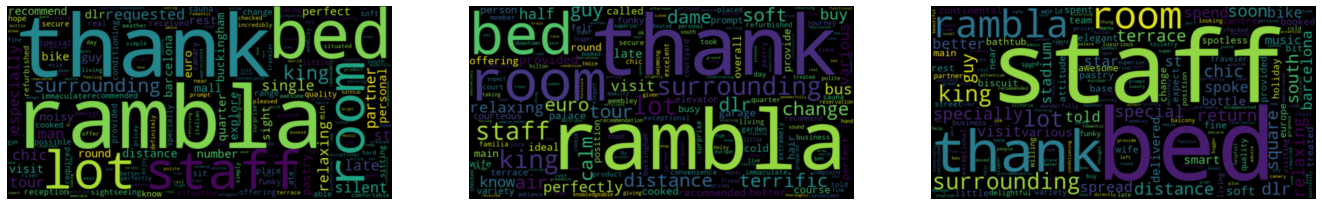

In [92]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [40, 10]

# Create subplots for each Topic
for index, topic in enumerate(topics):
    wc = WordCloud(width = 1000, height = 500).generate(' '.join(topic))
    
    plt.subplot(2, 5, index+1)
    plt.imshow(wc, interpolation="quadric")
    plt.axis("off")
    #plt.title(hand_labels[index])
    
plt.show()

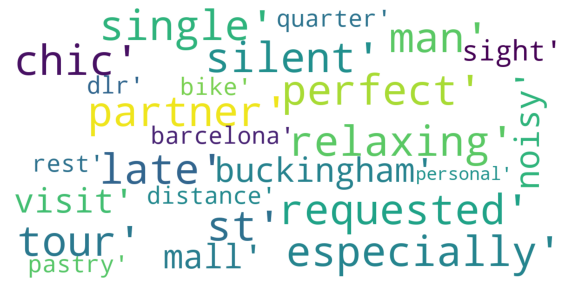

In [86]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 25,
        max_font_size = 30, 
        scale = 3,
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(topics[0])

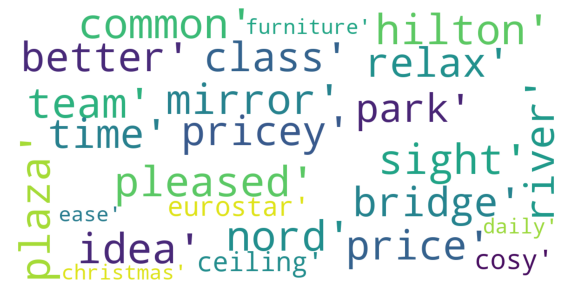

In [75]:
show_wordcloud(topics[1])

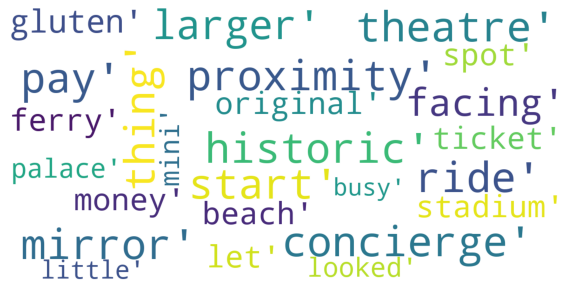

In [76]:
show_wordcloud(topics[2])

In [94]:
show_wordcloud(fitted_neg)

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [ ]:
# Checking monthly trend, consistent scoring
monthdf = data[['Review_Date','Average_Score','Reviewer_Score']]

In [ ]:
monthdf['Review_Date'] = pd.to_datetime(monthdf['Review_Date'])

In [ ]:
monthdf['Review_Date'] = monthdf['Review_Date'].apply(lambda x: x.strftime('%Y-%m'))

In [ ]:
monthdf['City'] = city

In [ ]:
monthdf

In [ ]:
monthdf = monthdf.groupby(['Review_Date', 'City']).agg({'Average_Score':'mean', 'Reviewer_Score':'mean'})

In [ ]:
monthdf.reset_index(inplace=True)

In [ ]:
monthdf.sort_values('City')

In [ ]:
mapdf.describe()

In [113]:
#mapping
mapdf = data[['Hotel_Name', 'Average_Score', 'lat', 'lng']]
mapdf = mapdf.groupby(['Hotel_Name']).agg({'Average_Score':'mean', 'lat':'mean', 'lng':'mean'})
mapdf = mapdf.dropna()
mapdf.reset_index(inplace=True)

In [121]:
mapdf['color'] = pd.cut(mapdf['Average_Score'], bins=[0,8.1,8.5,8.9,10], 
                              labels=['red', 'orange', 'blue', 'green'])

In [123]:
import folium
m = folium.Map(location=[52.360576, 4.915968])

for i in range(mapdf.shape[0]):
    folium.CircleMarker([mapdf['lat'][i],mapdf['lng'][i]], tooltip=f'{mapdf["Hotel_Name"][i]} : {mapdf["Average_Score"][i]:0.2}', color=mapdf['color'][i]).add_to(m)
m

In [154]:
mapdf[mapdf['color']=='green'].sort_values('Average_Score', ascending=False)

,Hotel_Name,Average_Score,lat,lng,color
1186,Ritz Paris,9.8,48.867947,2.328959,green
3,41,9.6,51.498147,-0.143649,green
467,H tel de La Tamise Esprit de France,9.6,48.864866,2.329576,green
476,H10 Casa Mimosa 4 Sup,9.6,41.396211,2.162117,green
494,Haymarket Hotel,9.6,51.508459,-0.131138,green
...,...,...,...,...,...
289,Drawing Hotel,8.9,48.864438,2.335915,green
196,Canary Riverside Plaza Hotel,8.9,51.506699,-0.028021,green
1465,XO Hotel,8.9,48.882749,2.298278,green
219,Chasse Hotel,8.9,52.369672,4.861448,green


In [ ]:
# blank dictionary of values
# Take in reviews
# Remove Stop words and Lemmatize
# tfidf neg words
# tfidf pos words
# tfidf pos - tfidf neg
# tfidf ngrams
# get range
# some small range=0
# normalize values from - to -1 based on * rating above or below
# normalize values from + to 1
# add values to dictionary
# dictionary of values
#

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_pos = count.fit_transform(pos_content.values.astype('U'))
tfidf_neg = count.fit_transform(neg_content.values.astype('U'))

In [ ]:
cleanest

In [128]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/slindhult/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

In [ ]:
print_sentiment_scores('If I had to choose something it would be that the nice big bed was covered by two single quilts rather than a double')

In [143]:
a = analyser.lexicon.keys()
b = analyser.lexicon.values()

In [144]:
hotel_lexicon = {k:v for k,v in zip(a,b)}

In [153]:
hotel_lexicon['walk']

KeyError: 'walk'

In [ ]:
snt = analyser.polarity_scores('No Positive')

In [ ]:
snt['compound']

In [ ]:
data["Negative_Review"] = data["Negative_Review"].apply(lambda x: str(x).replace("No Negative", ""))
data["Positive_Review"] = data["Positive_Review"].apply(lambda x: str(x).replace("No Positive", ""))

In [ ]:
neg = data['Negative_Review']
neg_review_sentiment = []
for i in neg:
    snt = analyser.polarity_scores(i)
    neg_review_sentiment.append(snt['compound'])


In [ ]:
pos = data['Positive_Review']
pos_review_sentiment = []
for i in pos:
    snt = analyser.polarity_scores(i)
    pos_review_sentiment.append(snt['compound'])


In [ ]:
vader

In [ ]:
cleanest.info()

In [ ]:
cleanest = pd.read_csv('cleanest.csv')

In [ ]:
cleanest["Neg_Review_Clean"] = cleanest["Neg_Review_Clean"].apply(lambda x: str(x).replace("No Negative", ""))
cleanest["Pos_Review_Clean"] = cleanest["Pos_Review_Clean"].apply(lambda x: str(x).replace("No Positive", ""))
                                                                  

In [ ]:
cleanest

In [ ]:
vader = cleanest.copy()

In [ ]:
#vader.drop(['neg_review_sentiment', 'pos_review_sentiment'], axis=1, inplace=True)
vader['pos_sent'] = pos_review_sentiment
vader['neg_sent'] = neg_review_sentiment

In [ ]:
vader.drop(['Unnamed: 0', 'Unnamed: 0.1','Neg_Review_Clean', 'Pos_Review_Clean'], axis=1, inplace=True)

In [ ]:
vader.to_csv('vader.csv')

In [ ]:
vader.drop('Additional_Number_of_Scoring', axis=1, inplace=True)

In [ ]:
vader[vader['pos_sent']<-0.5]

In [ ]:
vader[vader['neg_sent']>0]

In [ ]:
data['Positive_Review'][577]

In [ ]:
vader

In [ ]:
data['Hotel_Address'][455551]

In [ ]:
city = data['Hotel_Address']
for idx, i in enumerate(city):
    if 'Amsterdam' in i:
        city[idx] = 'Amsterdam'
    if 'Vienna' in i:
        city[idx] = 'Vienna'
    if 'Milan' in i:
        city[idx] = 'Milan'
    if 'Barcelona' in i:
        city[idx] = 'Barcelona'
    if 'Paris' in i:
        city[idx] = 'Paris'
    if 'London' in i:
        city[idx] = 'London'
        

In [ ]:
city = pd.Series(city)

In [ ]:
vader['City'] = city

In [ ]:
cities = pd.get_dummies(vader['City'])
vader = vader.join(cities)
vader.drop(['City'], axis=1, inplace=True)

In [ ]:
vader

In [ ]:
data.head()

In [ ]:
from sklearn.naive_bayes import GaussianNB 
NB = GaussianNB()
neg_pos = data['Reviewer_Score'] > 7.25
sentiment_predictor = NB.fit(tfidf_pos, neg_pos)
sentiment_predictor.

In [ ]:
plt.hist(data['Reviewer_Score'], bins = 40)

In [ ]:
data['Reviewer_Score'].std()

In [ ]:
data['Reviewer_Score'].mean()

In [ ]:
8.395-3*1.637

In [ ]:
a = data['Reviewer_Score']<3
a.sum()

In [ ]:
lemmed = pd.read_csv('lemmed.csv')

In [ ]:
lemmed["Negative_Review"] = lemmed["Negative_Review"].apply(lambda x: str(x).replace("No Negative", ""))
lemmed["Positive_Review"] = lemmed["Positive_Review"].apply(lambda x: str(x).replace("No Positive", ""))
lemmed["Neg_Review_Clean"] = lemmed["Neg_Review_Clean"].apply(lambda x: str(x).replace("No Negative", ""))
lemmed["Pos_Review_Clean"] = lemmed["Pos_Review_Clean"].apply(lambda x: str(x).replace("No Positive", ""))

In [ ]:
lemmed

In [ ]:
lemmed["Pos_Review_Clean"][3]

In [ ]:
spell = SpellChecker()
sp = []
for i in lemmed['Pos_Review_Clean']:
    misspelled = spell.unknown(word_tokenize(i))
    for w in misspelled:
        sp.append(w)

In [ ]:
sorted(set(sp))

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')

In [ ]:


spell = SpellChecker()
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
 
neg_dict = {}
for idx, i in enumerate(lemmed['Neg_Review_Clean']):
    for w in word_tokenize(i):
        w=w.lower()
        if w.isalpha():
            if w not in neg_dict.keys():
                neg_dict[w] = 0
            try:
                neg_dict[w]-=(1/len(word_tokenize(i))*data['differential'][idx])
            except KeyError:
                continue

In [ ]:
sorted(neg_dict.values())

In [ ]:
pos_dict = {}
for i in lemmed['Pos_Review_Clean']:
    for w in word_tokenize(i):
        w=w.lower()
        if w.isalpha():
            if w not in neg_dict.keys():
                pos_dict[w] = 0
            try:
                pos_dict[w]-=(1/len(word_tokenize(i))*data['differential'][idx])
            except KeyError:
                continue

In [ ]:
sorted(pos_dict.values())[::-1]

In [ ]:
len(pos_dict.keys())

In [ ]:
len(neg_dict.keys())

In [ ]:
merged_dict = neg_dict.copy()

for i in pos_dict.keys():
    if i not in merged_dict.keys():
        merged_dict[i]=0
    merged_dict[i] += pos_dict[i]

In [ ]:
sorted(merged_dict.items(), key=(lambda item: item[1]))[70000:]

In [ ]:
len(merged_dict.items())

In [ ]:
vader

In [ ]:
len(edited_dict.items())

In [ ]:
sorted(edited_dict.items(), key=(lambda item: item[1]))

In [ ]:
sent_dict = {key:val for key, val in merged_dict.items() if key in edited_dict.keys()}

In [ ]:
sent_dict

In [ ]:
data['Negative_Review'][0]

In [ ]:
class Hotel_Sentiment_Analyzer:
    from sklearn.feature_extraction.text import TfidfVectorizer
    '''Hotel Sentiment Analyzer class
    Fit takes in X an array of reviews as strings '''
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
        tfidf_pos = count.fit_transform(pos_content.values.astype('U'))
        tfidf_neg = count.fit_transform(neg_content.values.astype('U'))
    
    def predict(self, X):
        pass

In [125]:
data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968
